# Google Colab Setup

In [1]:
#@title Setup Google Colab by running this cell only once (ignore this if run locally) {display-mode: "form"}
import sys
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/epfl-exts/amld24-applications-ML-workshop.git
        
    # Copy files required to run the code
    !cp -r "amld24-applications-ML-workshop/text_classification_case_study/data" "amld24-applications-ML-workshop/text_classification_case_study/tools.py" .
    
    # Install packages via pip
    !pip install -r "amld24-applications-ML-workshop/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

# Text classification :: Overview

## Task 

We want to build a Spam detector which, given examples of spam emails (e.g. flagged by users) and examples of regular (non-spam, also called "ham") emails, learns how to flag new unseen emails as spam or non-spam.

## Data

We will use the [SpamAssassin](https://spamassassin.apache.org/) public email corpus. This dataset contains ~6'000 labeled emails with a ~30% spam ratio. If you want to learn more about this dataset, check [this](https://spamassassin.apache.org/old/publiccorpus/). (*Note: Datasets of text are called corpora and samples are called documents.*) 

The dataset has been downloaded for you and is available in the *data* folder.

## Notebook overview

* Load the data
* Text preprocessing
* Data exploration
* Feature extraction
* Build a spam detector
* What did our model learn? Error analysis

# Text classification :: Spam detection


## Load the data

In [2]:
# Load libraries and helper functions
import tools

In [3]:
# Load the data
df = tools.load_data()

Data loaded.
Data size: (5832, 2)


Let's check the number of samples per class in the data.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: label, dtype: float64




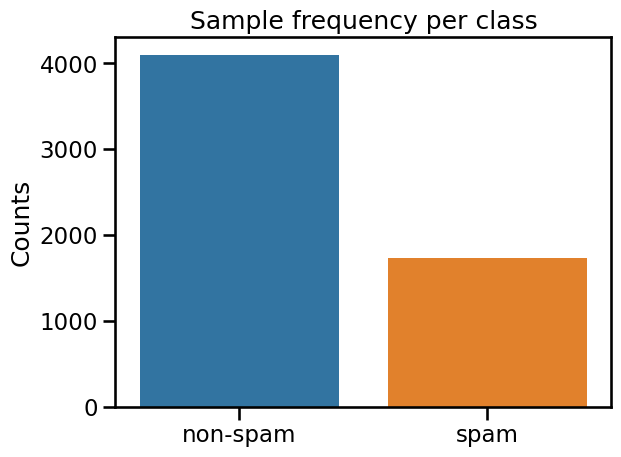

In [4]:
tools.plot_class_frequency(df)

Now, let's have a look at a few rows from the dataset.

***Note:*** The *label* is 0 for *non-spam* and 1 for *spam*.

In [5]:
# If you rerun this cell then you get a different set of samples displayed
df.sample(3)

,label,text
5455,0,"Yea.. this isn't newsworthy... This is a forwarded message From: Declan McCullagh <declan@well.com> To: politech@politechbot.com Date: Sunday, July 14, 2002, 8:06:38 PM Subject: FC: Bush administration readies nationwide informant program ===8<==============Original message text=============== The link: http://www.citizencorps.gov/tips.html --- Date: Sun, 14 Jul 2002 20:59:54 +0000 From: ""J.D. Abolins"" <jda-ir@njcc.com> Subject: Aussie paper: US planning to recruit one in 24 Americans as citizen spies Anybody ever heard of Pavlik Morozov? (If not see http://www.cyberussr.com/rus/morozov.html for a quick blurb about the fellow.) When I see proposals to mobilize American people into being eyes and ears fo the government, I am reminded of Pavilik and his family. Now I am not against people reporting certain things to the police. It is the habit of being constantly suspicious of neighbors, co-workers, and otehrs that can become destructive. Down the line it can lead to suspicions based not on significant clues but upon things such as ""fails to display sufficient respect for authority"", ""laughs whenever the phrase 'homeland security' is used"", and ""hangs out with anti-social misfits."" It is an all too easy slide from neighbors watching out for each and helping the community to becoming agents of the state. J.D. Abolins PS: Why is it that the most revealing news reports about the USA are coming nowadays form the UK, Aussie, and other non-USA media? <rhetorical> -------------- From the Sydney Morning Herald Web site 15 July 2002 http://www.smh.com.au/articles/2002/07/14/1026185141232.html US planning to recruit one in 24 Americans as citizen spies By Ritt Goldstein July 15 2002 The Bush Administration aims to recruit millions of United States citizens as domestic informants in a program likely to alarm civil liberties groups. The Terrorism Information and Prevention System, or TIPS, means the US will have a higher percentage of citizen informants than the former East G..."
3342,0,"Yes, I enjoyed it. Then afterwards, there was a debate thing on ITV about genius or madness, featuring a friend of mine's boss plus David Icke, also the very likeable Evelyn Glennie. Dave To unsubscribe from this group, send an email to: forteana-unsubscribe@egroups.com Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/"
77,1,"<html> <body> <p>Do you like Sexy Animals doing the wild thing? We have the super hot content on the Internet!<br> This is the site you have heard about. Rated the number one adult site three years in a row!<br> - Thousands of pics from hardcore fucking, and cum shots to pet on girl.<br> <br> - Thousands videos<br> <br> So what are you waiting for?<br> <br> <b><font size=""5""><a href=""http://6.lspeedhost.net/wfs/?aid=283360"">CLICK HERE</a></font><br> </b> <br> <b>YOU MUST BE AT LEAST 18 TO ENTER!</b></p> <p>&nbsp;</p> <p>&nbsp;</p> <p>&nbsp;</p> <p><font size=""2"">You have received this advertisement because you have opted in to receive <br> free adult internet offers and <br> <br> specials through our affiliated websites. If you do not wish to receive <br> further emails or have received the <br> <br> email in error you may opt-out of our database by clicking here: <br> <a href=""http://16.lspeedhost.net/alw/takemeoff.html"">CLICK HERE</a><br> Please allow 24hours for removal.<br> This e-mail is sent in compliance with the Information Exchange Promotion and<br> Privacy Protection Act. <br> <br> section 50 marked as 'Advertisement' with valid 'removal' instruction.</font></p> </body> </html> [NKIYs5]"


## Text preprocessing

Good text preprocessing is an essential part of every NLP project!

Our goal here is to build a model that distinguishes non-spam from spam. The idea here is to "clean" and "standardize" raw text before feeding it to our machine learning model. We need to keep as many "informative" words as possible, while discarding the "uniformative" ones. Removing unnecessary content, i.e. the "noise", from our texts will help to improve the accuracy of our models.

## 💡 Observations

- There are some items in the text that should be removed to make it readable. Here are some suggestions:

* HTML tags 
* URLs
* E-mail addresses
* Punctuation marks, digits (e.g. 2002, 1.1, ...)
* Multiple whitespaces
* Case conversion (e.g. Dog vs dog, ...)
* English STOPWORDS (e.g. a, is, my, i, all, and, by...)
* ...

- It is likely that the number of occurrences of the above items (HTML tags, URLs, etc) is helpful to distinguish spam from non-spam. Similarly, the length of the emails and the frequency of punctuation marks or upper case letters may also give us clues as to whether we are dealing with spam or not.

The *clean_corpus* function below will take care of the parts raised in the 1st observation. For the ideas from the 2nd observation we will create new features and investigate their effects in the subsection **What about "spammish" signatures?**. 

In [7]:
import pandas as pd
import numpy as np

pd.set_option("max_colwidth", 2000)

import warnings

warnings.filterwarnings("ignore")

import os
import email
import re
import string
import nltk
import textwrap
from bs4 import BeautifulSoup
from collections import Counter
from random import randrange

In [8]:
# Compile Regex patterns
mail_pattern = re.compile(r"[<\[(]?[\w][\w.-]+@[\w.]+[>\])]?[:=]?[0-9]{0,}")
url_regex = r"[<]?https?:\/\/(www\.)?[-a-zA-Z0-9@:,%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@,:%_\+.~#?&//=]*)[>]?"
url_pattern = re.compile(url_regex)
mention_pattern = re.compile(r"@[\w.-]+")
hashtag_pattern = re.compile(r"#[\w]+")

In [12]:
docs.sample()

1918    <HTML><HEAD><TITLE>Free Card Search</TITLE> <META HTTP-EQUIV="Content-Type" CONTENT="text/html; charset=iso-8859-1"> </HEAD><BODY BGCOLOR="#000000"><div align="center"> <a href="http://mbf.%61%66%66%69%6c%69%61%74%65%6e%65%74%74%2e%63%6f%6d/fcard/"> <IMG SRC="http://mbf.%61%66%66%69%6c%69%61%74%65%6e%65%74%74%2e%63%6f%6d/fcard/ad/new_fcard.jpg" WIDTH=523 HEIGHT=373 border="0"></a> </div><TABLE WIDTH=523 BORDER=0 CELLPADDING=0 CELLSPACING=0 align="center"> <TR><td colspan=7 align=left><br><font color="white" size="1" face="arial"> Sincerely,<BR><B>Your New Offers Staff</B><BR></FONT> <FONT SIZE="-2"><A HREF="mailto:montage@btamail.net.cn?subject=Remove">Remove</A></FONT> </td></tr></TABLE></BODY></HTML>
Name: text, dtype: object

In [31]:
df["text"].sample(2)

3302    > > You're probably running exmh on a local machine. I'm running it on a > > very remote machine. In this scenario, the mime handling is weak. > > Nope. I run exmh on my desktops at home and at work with the resulting > exmh windows being displayed on both my work and home desktops (gratis > SSH X11 forwarding). I run exmh routinely from home (broadband) using an XWindows Client tunneled through ssh under <ahem> WinXP. It works very well in this fashion. FWIW, I use Eudora under Winder$ because it's less of a virus magnet. :) There's more to the story why I run Winder$, but that's really off-topic and I'm already guilty! -=d _______________________________________________ Exmh-users mailing list Exmh-users@redhat.com https://listman.redhat.com/mailman/listinfo/exmh-users
1530                                                                                           <HTML> <BODY> </head> <BODY> <p>.&nbsp;&nbsp; These are REAL people with REAL livecameras and movies!<a href="http:

In [39]:
type(docs)

pandas.core.series.Series

In [37]:
docs = df["text"][1529:1531]
# docs = [ '<HTML><HEAD><TITLE>Free Card Search', 'Dear Homeowner, Interest']
docs

1529    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN"> <!-- saved from url=3D(0022)http://internet.e-mail --><HTML><HEAD><TITLE>N= ew Web Technology</TITLE> <META http-equiv=3DContent-Type content=3D"text/html; charset=3Dwindows-12= 52"> <META content=3D"MSHTML 6.00.2713.1100" name=3DGENERATOR></HEAD> <BODY vLink=3D#c0c0c0 link=3D#c0c0c0 bgColor=3D#ffffff leftMargin=3D0><FON= T face=3DArial> <P> <CENTER> <TABLE width=3D500 border=3D0> <TBODY> <TR> <TD align=3Dmiddle><B><FONT color=3D#336633 size=3D5>Mortgage Rates Sl= ashed For The Last Time!</FONT></B> <HR> <FONT color=3D#000000 size=3D2><B>Let us help you get a new mortgage= for up to 100% of your home=FFFFFF92s value</B> <P> <TABLE width=3D300 border=3D0> <TBODY> <TR> <TD align=3Dleft><FONT color=3D#000000 size=3D4> <LI>Lower your monthly payment! <LI>Consolidate your debt! <LI>Shorten the term of your loan! <LI>Reduce your interest rate! </FONT></LI></TD></TR></TBODY><= /TABLE> <P><FONT color=3D#ff0000 size=3D3><B>N

In [117]:
docs = pd.Series(['<html> <body bgcolor="#FFFBE0"> Immediate Help Needed. We are a fortune 500 company that is growing at a tremendous rate of over 1000% per year. We simply cannot keep up. We are looking for motivated individuals who are looking to earn a substantial income working from home. This is a real opportunity to make an excellent income from home. No experience is required. We will provide you with any training you may need. We are looking for energetic and self motivated people. If that is you than click on the link below and complete our online information request form, and one of our employment specialist will contact you by info@zhoster.com. So if you are looking to be employed at home, with a career that will provide you vast opportunities and a substantial income, please fill out our online information request form here now: http://www.zhoster.com:8080/homeopp/ To be removed from our list simply click on the link below now: http://www.zhoster.com:26000/homeopp/remove.html 6115CNUY4->>341mBpO6887',
                  '<HTML> <BODY> These are <a href="http://abc.ch">', 
                  'abc@de.fg running', 
                  'aa bb cc<', 
                  '123 ABC']
                )
docs

0    <html> <body bgcolor="#FFFBE0"> Immediate Help Needed. We are a fortune 500 company that is growing at a tremendous rate of over 1000% per year. We simply cannot keep up. We are looking for motivated individuals who are looking to earn a substantial income working from home. This is a real opportunity to make an excellent income from home. No experience is required. We will provide you with any training you may need. We are looking for energetic and self motivated people. If that is you than click on the link below and complete our online information request form, and one of our employment specialist will contact you by info@zhoster.com. So if you are looking to be employed at home, with a career that will provide you vast opportunities and a substantial income, please fill out our online information request form here now: http://www.zhoster.com:8080/homeopp/ To be removed from our list simply click on the link below now: http://www.zhoster.com:26000/homeopp/remove.html 6115CNUY4-

In [118]:
# Count HTML Tags
for d in docs:
    soup = BeautifulSoup(d, "html.parser")
    print(len(soup.findAll()))

2
3
0
0
0


In [119]:
for doc in docs:
    d = mail_pattern.sub("EMAILHERE", doc)
    print(d.count("EMAILHERE"))
        

1
0
1
0
0


In [120]:
for doc in docs:
    # Count URLs (e.g. https://lists.sourceforge.net/lists/listinfo/razor-user)
    doc = url_pattern.sub("URLHERE", doc)
    print(doc.count("URLHERE"))

2
1
0
0
0


In [121]:
docs.apply(lambda x: len([x for x in x if x in string.punctuation]))

0    45
1    13
2     2
3     1
4     0
dtype: int64

In [123]:
docs.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

0    0
1    2
2    0
3    0
4    1
dtype: int64

In [124]:
docs.apply(
    lambda x: len([wrd for wrd in x.split() if wrd.islower()])
)

0    141
1      3
2      2
3      3
4      0
dtype: int64

In [125]:
docs.apply(lambda x: len([x for x in x if x.isdigit()]))

0    29
1     0
2     0
3     0
4     3
dtype: int64

In [55]:
docs.apply(lambda x: len([x for x in x if x.isalpha()]))

0    31
1    20
2     6
3     6
dtype: int64

In [128]:
len(set(docs[0].split()))

100

In [145]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
len(ENGLISH_STOP_WORDS)

318

In [136]:
txt='Immediate Help Needed We are a fortune company that is growing at a tremendous rate of over per year We simply cannot keep up We are looking for motivated individuals who are looking to earn a substantial income working from home.This is a real opportunity to make an excellent income from home No experience is required We will provide you with any training you may need We are looking for energetic and self motivated people If that is you than click on the link below and complete our online information request form and one of our employment specialist will contact you by So if you are looking to be employed at home with a career that will provide you vast opportunities and a substantial income please fill out our online information request form here now To be removed from our list simply click on the link below now CNUY mBpO'
txt.lower()

'immediate help needed we are a fortune company that is growing at a tremendous rate of over per year we simply cannot keep up we are looking for motivated individuals who are looking to earn a substantial income working from home.this is a real opportunity to make an excellent income from home no experience is required we will provide you with any training you may need we are looking for energetic and self motivated people if that is you than click on the link below and complete our online information request form and one of our employment specialist will contact you by so if you are looking to be employed at home with a career that will provide you vast opportunities and a substantial income please fill out our online information request form here now to be removed from our list simply click on the link below now cnuy mbpo'

In [138]:
len([w for w in txt.lower().split() if w in ENGLISH_STOP_WORDS])

85

In [139]:
len(txt.lower().split())

150

In [141]:
txt1 = " ".join([w for w in txt.lower().split() if w not in ENGLISH_STOP_WORDS])
len(txt1.split())

65

In [142]:
txt1

'immediate help needed fortune company growing tremendous rate year simply looking motivated individuals looking earn substantial income working home.this real opportunity make excellent income home experience required provide training need looking energetic self motivated people click link complete online information request form employment specialist contact looking employed home career provide vast opportunities substantial income online information request form removed list simply click link cnuy mbpo'

In [93]:
df = tools.clean_corpus(df)

print("Data cleaned")

Data cleaned


Let's have a look at a few "cleaned" examples.

In [96]:
tools.show_clean_text(df)


Original document:

> From: Hal DeVore <haldevore@acm.org> > Date: Tue, 01 Oct 2002 23:22:14 -0500 > > I've had this
binding in my ~/.exmh/exmhbindings for years: > > set {bindings(key,Flist_FindUnseen 1 ;
Inc_PresortFinish)} <Key-f> > > After updating to the current code in CVS I get "bad key f" when > I
hit the "f" key. I can open the Bindings... Commands window > and define the binding. It then works
until I restart exmh. > > I suspect a parsing problem/change. I'll try to look into this > tomorrow
unless someone knows where the problem might be. Flist_FindUnseen has changed to Flist_FindSeqs. It
takes the same arguments, but I changed the name because it looks for all the sequences, not just
the unseen sequence. Chris -- Chris Garrigues http://www.DeepEddy.Com/~cwg/ virCIO
http://www.virCIO.Com 716 Congress, Suite 200 Austin, TX 78701 +1 512 374 0500 World War III: The
Wrong-Doers Vs. the Evil-Doers.

Cleaned document:

devore date binding exmh exmhbindings years bindings flistfin

## Data Exploration :: What makes spam distinct?

### Frequent words

Which words distinguish spam from non-spam? Can we  identify the words in a text that are the most informative about its topic?

Let's find the 10 most frequent words in spam and non-spam and compare them.

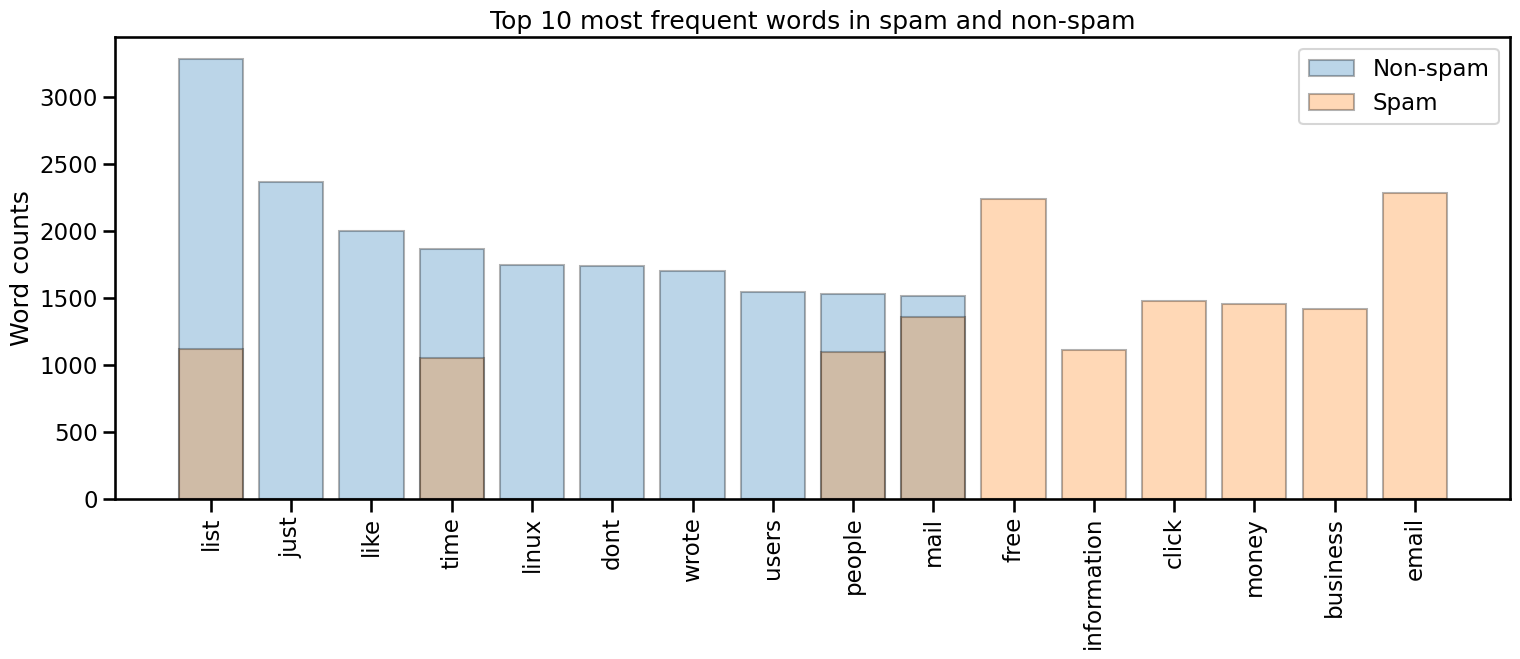

In [97]:
tools.plot_most_common_words(df=df, N=10)

## 💡 Observations

**Frequent "spammish" words**: 

* free
* email
* click
* business
* money

**Frequent "non-spammish" words**:

* just
* like
* linux
* wrote
* users  

**Occur in both top 10 but could be useful for distinctions**:

* list
* time

**Occur in both top 10 but are unlikely to be useful**:

* people
* mail

<div class="alert alert-success">
    
Let's change `N=10` to `N=30` and compare the outcome.
</div>

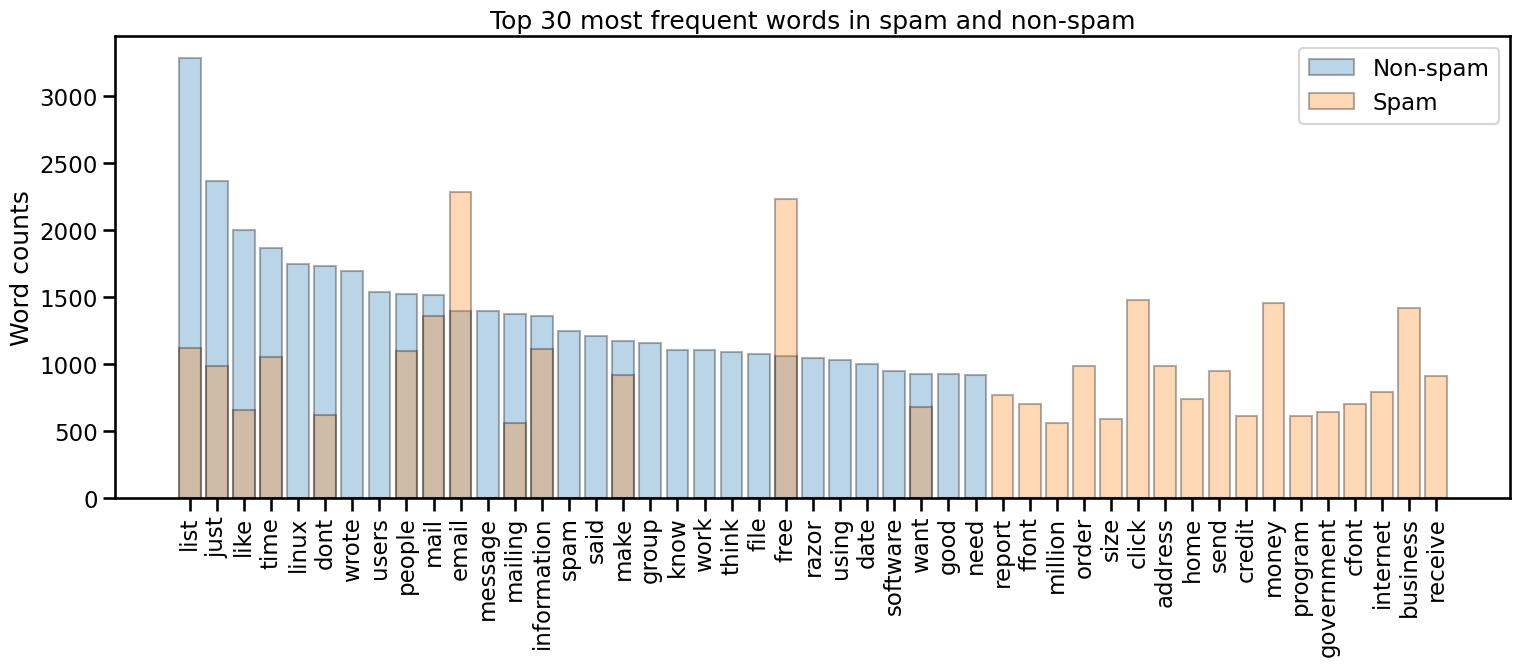

In [98]:
tools.plot_most_common_words(df=df, N=30)

## 💡 Observations

As we use more top words we get more overlap between the classes.  
However words like _email_ or _free_ are still mch more frequent in the **spam** class 

### What about "spammish" signatures?

* Do spams contain more HTML tags? 
* Does non-spam contain more URLs and E-mail adresses? 
* Are spams mails longer than non-spam? 
* ...

Let's find out!

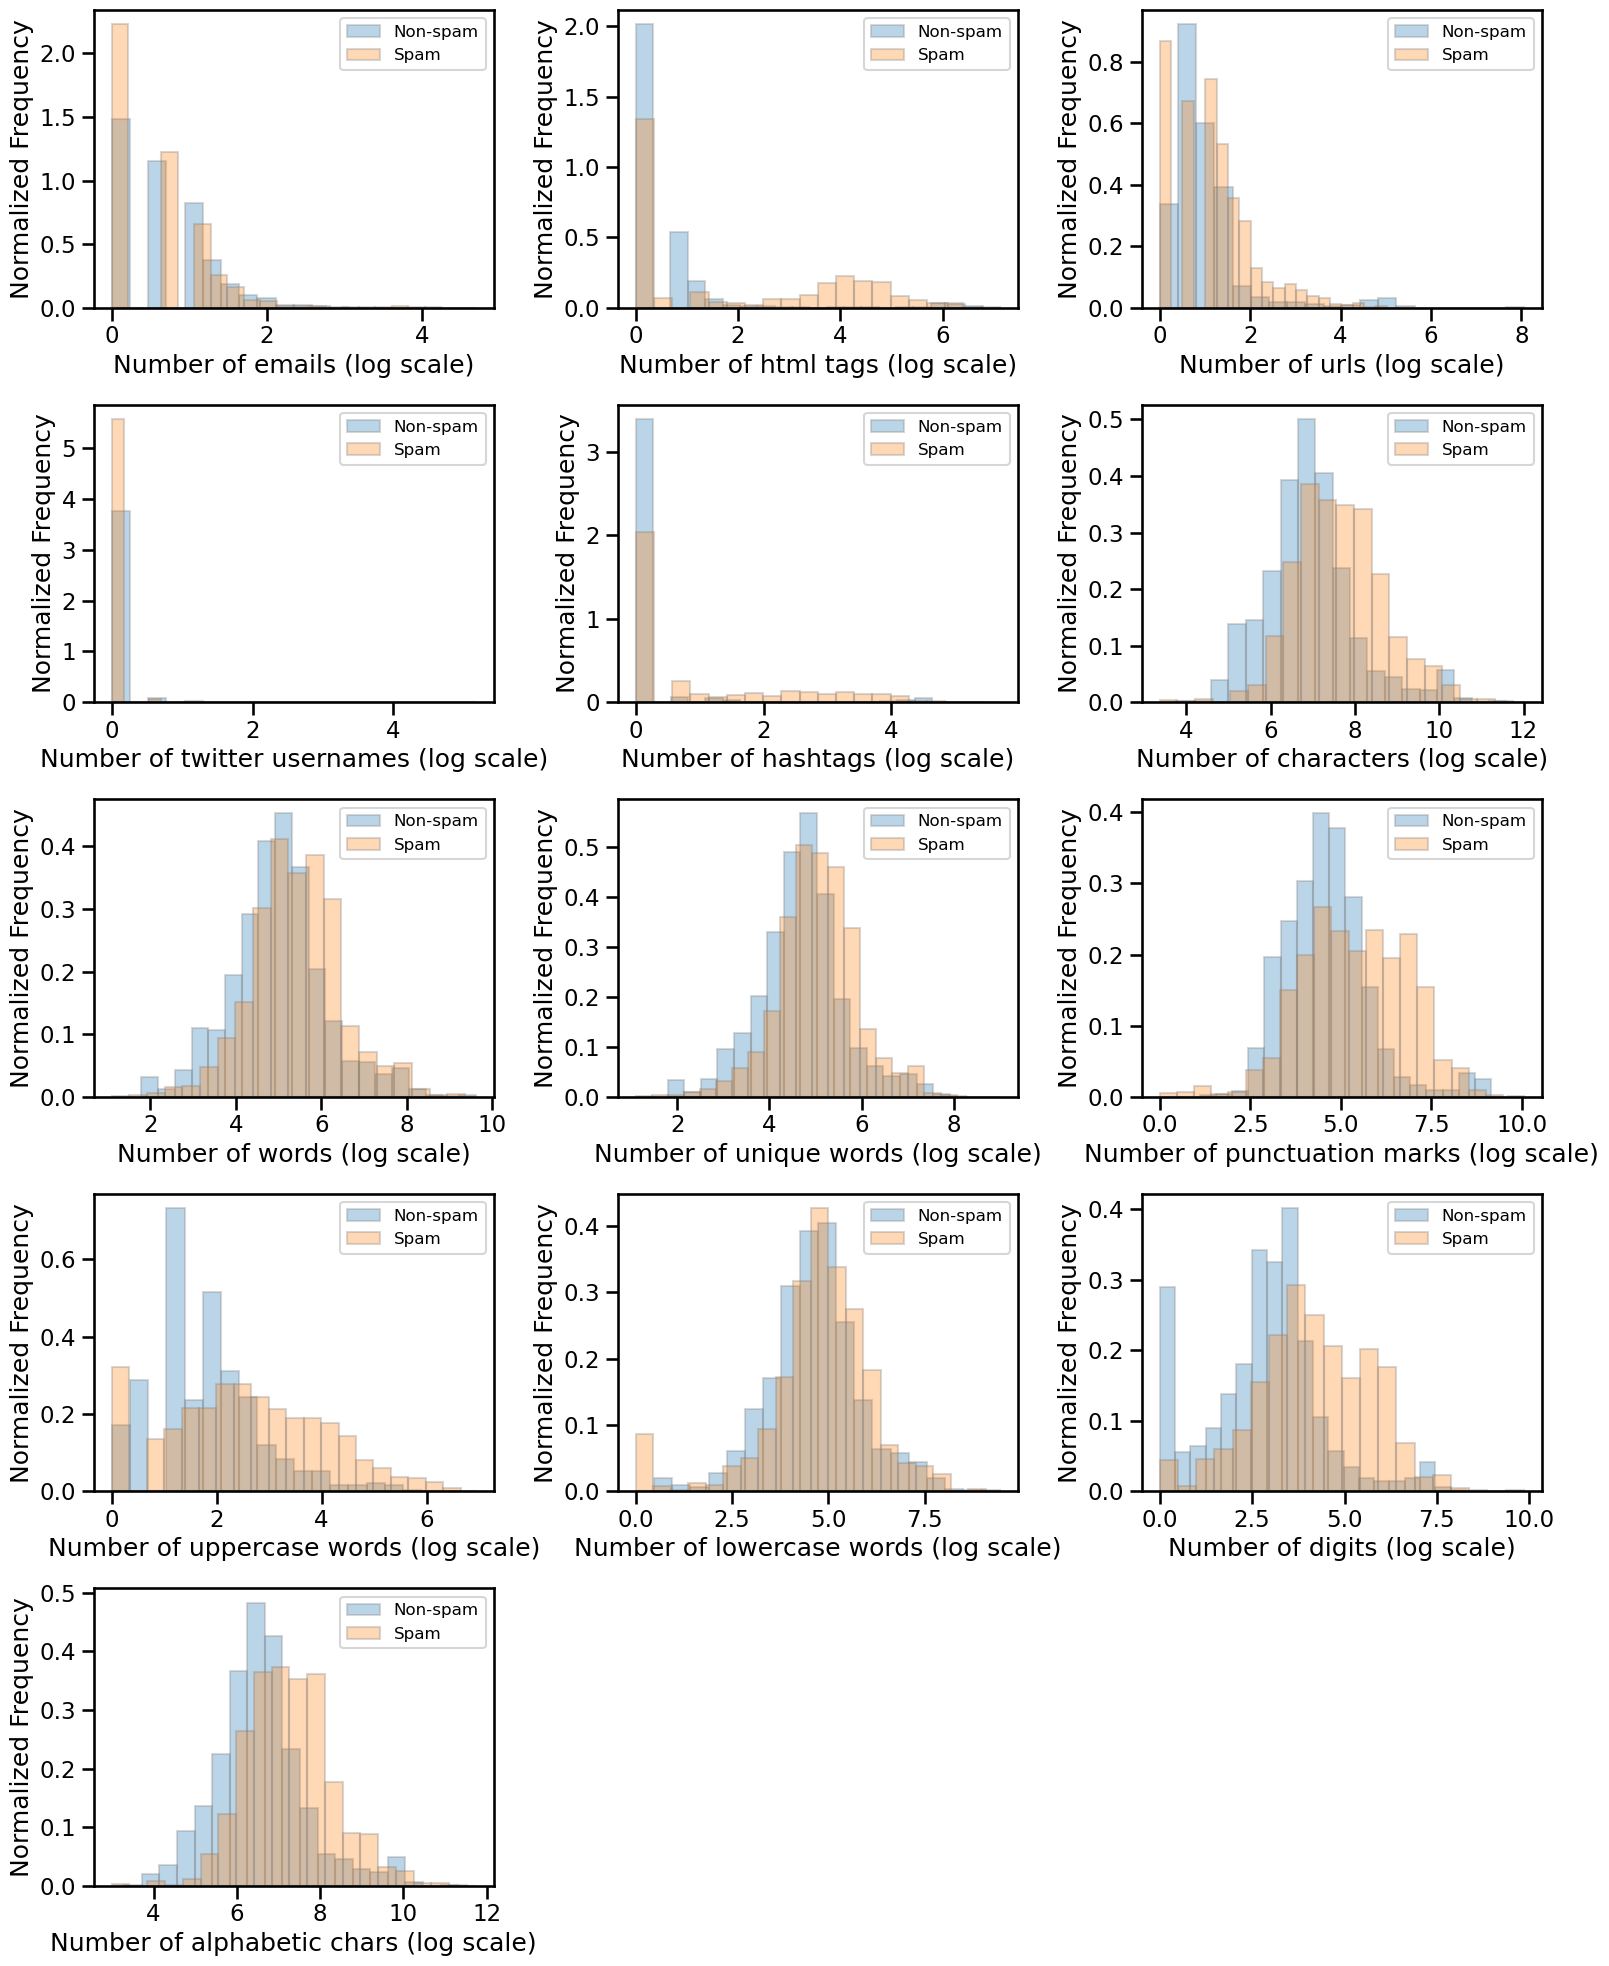

In [99]:
features = tools.get_features(df=df)

## Feature engineering :: Extracting features from text

Computers don't understand natural language. So, how do we represent text?

One of the simplest but effective and commonly used models to represent text for machine learning is the ***Bag of Words*** model ([online documentation](https://en.wikipedia.org/wiki/Bag-of-words_model)). When using this model, we discard most of the structure of the input text (word order, chapters, paragraphs, sentences and formating) and only count how often each word appears in each text. Discarding the structure and counting only word occurencies leads to the mental image of representing text as a "bag".  

**Example:** Let our toy corpus contain four documents.

$ corpus = ['I\;enjoy\;paragliding.',  $  
$\hspace{2cm}'I\;like\;NLP.',$  
$\hspace{2cm}'I\;like\;deep\;learning.',$  
$\hspace{2cm}'O\;Captain!\;my\;Captain!']$ 

In [100]:
tools.show_bag_of_words_vector()

,captain,deep,enjoy,i,learning,like,my,nlp,o,paragliding
Text,,,,,,,,,,
I enjoy paragliding.,0,0,1,1,0,0,0,0,0,1
I like NLP.,0,0,0,1,0,1,0,1,0,0
I like deep learning.,0,1,0,1,1,1,0,0,0,0
O Captain! my Captain!,2,0,0,0,0,0,1,0,1,0


Bag of Words has converted all documents into numeric vectors. Each column represents a word from the corpus and each row one of the four documents. The value in each cell represents the number of times that word appears in a specific document. For example, the fourth document has the word `captain` occuring twice and the words `my` and `O` occuring once.

## Build a spam detector

In the previous section, we saw how to perform text preprocessing and feature extraction from text. We are now ready to build our machine learning model for detecting spams. We will use a Logistic Regression classifier ([online documentation](https://en.wikipedia.org/wiki/Logistic_regression)).

First, split the data into two sets: the `train` set and the `test` set. We will then use the train set to `fit` our model. We will use 5-fold cross-validation. So the validation sets are automatically created internally. The test set will be used to `evaluate` the performance of our model. 

### Baseline

70.3% of samples are non-spam. This naive baseline model would reach 70+% for doing very little.

### Spam classification

In [ ]:
# Train/test splitting
df_train, df_test = tools.train_test_split_(df)

# Fit model on the train data
model = tools.fit_model(df_train)

# Print predictions on test set
tools.plot_confusion_matrix(df_test, model);

**Confusion matrices**  

Confusion matrices are a nice way of evaluating the performance of models for classification models. Rows correspond to the true classes and the columns to the predicted classes. Entries on the main diagonal of the confusion matrix correspond to correct predictions while the other cells tell us how many mistakes made our model ([online documentation](https://en.wikipedia.org/wiki/Confusion_matrix)).

* The first row represents non-spam mails: 1'192 were correctly classified as 'non-spam', while 24 (~1,9%) were misclassified as 'spam'.
* The second row represents spam mails: 435 were correctly classified as 'spam', while 15 (~3,3%) were misclassified as 'non-spam'.

Our model did quite well!

### What did our model learn from the data?

Our logistic regression model has learned which words are the most indicative of non-spam and which words are the most indicative of spam. The positive coefficients on the right correspond to words that, according to the model, are indicative of spam. The negative coefficients on the left correspond to words that, according to the model, are indicative of non-spam.

In [ ]:
tools.visualize_coefficients(model, n_top_features=30)

## 💡 Observations

- According to the model, words such as "date", "wrote", "yahoo", "supplied", ... are strong indicators of non-spam.  

- Words such as "click", "removed", "sightings",  ... indicate spam.

- These results are consistent with our earlier analysis. For example we had identified "wrote", "said" and "linux" as potential indicators of non-spam ealier. Similarly "click", "credit", "free", and "money" suggested spam.

### Error analysis :: Where does our model fail?

We will now analyze the misclassified mails in order to get some insights on where the model failed to make correct predictions. The *error_analysis* function below will show us the top features responsible for the model making a decision of prediction whether the mail is spam or non-spam.

In [ ]:
tools.error_analysis(df_test, model, doc_nbr=16)